<a href="https://colab.research.google.com/github/gmmendez/EA2SOA/blob/master/EA3_Mendez_Gonzalo_39913544_Ejercicio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introduccion**

Para determinar la cantidad de agua necesaria que debe ser aplicada en el riego, es esencial conocer los requerimientos del cultivo (evapotranspiración) así como la cantidad de agua de lluvia aportada durante el periodo de crecimiento. La evapotranspiración (ET) es definida como la combinación de dos procesos físicos muy similares a través de los cuales el agua se pierde a la atmósfera, por un lado, desde la superficie del suelo por evaporación y, por otro, desde el cultivo por el proceso de transpiración.

En el presente ejercicio se presentan al productor agropecuario dos funcionalidades útiles que serán de gran ayuda a la hora de planificar su cultivo: en primer lugar, el mismo va a poder conocer la cantidad de milímetros de agua de lluvia que fue acumulada en la provincia de Buenos Aires para el año 2019, desglosado por cada mes. De esta manera, el productor podrá tomar decisiones respecto de su cultivo tomando como referencia la tabla con esta información. La información se obtiene de un archivo externo que se encuentra cargado en un repositorio de GitHub. A su vez, se ofrece al usuario la posibilidad de que toda esta información se descargue localmente en su terminal en formato de archivo txt.

En segundo lugar, se ofrece la funcionalidad para calcular la evapotranspiración del cultivo. La misma resulta del producto de la evapotranspiracion de referencia (ET0) por el coeficiente del cultivo (Kc). La evapotranspiración de referencia expresa el poder de evaporación de la atmósfera en un lugar (para este ejemplo, será la provincia de Buenos Aires) y tiempo específico del año y no tiene en cuenta la las características del cultivo y los factores del suelo. Cabe destacar que el cálculo de la misma presenta una dificultad elevada, con lo cual se suele obtener de la estación meteorológica más cercana al cultivo. El coeficiente del cultivo, por su parte, se define como la diferencia de evaporación y transpiración entre el cultivo de campo (ETc) y el cultivo de referencia (ET0). Algunos factores que afectan el coeficiente de cultivo son el tipo de cultivo (hojas, altura, propiedades aerodinámicas, espaciamiento de plantación); clima (velocidad del viento y humedad relativa); etapas de crecimiento del cultivo durante el desarrollo (inicial, de desarrollo, mediados de temporada y final de temporada), entre otros.


> ET = ET0 * Kc

En el presente ejercicio se utilizó la API pandas para trabajar con DataFrames, de esta manera fue posible importar toda la información de las precipitaciones en el año anterior, poder realizar gráficos sobre dicha información para que la misma se visualice de forma más amigable para el usuario. A su vez, pandas nos permite almacenar los datos obtenidos desde un archivo csv almacenado en un repositorio GitHub en un archivo txt que se descarga de forma automática en la terminal de trabajo del usuario.

Por otro lado, para la segunda parte del ejercicio, se utilizó OpenMP para poder realizar los cálculos en forma concurrente, ya que esta interfaz nos permite ejecutar una región establecida en el código en forma paralela, disparando hilos, cada uno de los cuales se ejecutarán sobre un procesador y realizará alguno de los cálculos.

En la segunda parte del ejercicio, el usuario puede encontrar dos vectores: el primero representa la evapotranspiracion de referencia (ET0) promedio para cada mes del año 2019, mientras que el segundo vector representa el coeficiente del cultivo (Kc) para diferentes tipos de cultivo. La información en cada vector será utilizada para calcular la evapotranspiracion en cada mes del año 2019 para los diferentes cultivos, ya que la operación que realiza el código del ejercicio se basa en multiplicar las distintas posiciones del primer vector por las distintas posiciones del segundo vector:


> ET[i] = ET0[i] * Kc[i]

El objetivo es que el productor pueda comparar la evapotranspiracion de los distintos cultivos en distintas épocas del año 2019, para que pueda tomar decisiones sobre cual es el momento más adecuado para sembrar/cosechar, o cualquier otro tipo de desicion que sea relevante para su trabajo.

**2. Armado del ambiente**

Para la ejecución del presente ejercicio, no es necesario ejecutar comandos previos para el armado del ambiente.

**3. Desarrollo**

A continuación se presentan las diferentes secciones que deben ser ejecutadas para mostrar tanto la información de las lluvias junto con sus gráficos, como para descargar automáticamente el archivo txt con dicha información.

A su vez se encuentra el desarrollo del cálculo de la evapotranspiración de distintos cultivos.

    Mes  Precipitaciones(milimetros)
0   Ene                          167
1   Feb                          171
2   Mar                          171
3   Abr                          110
4   May                           72
5   Jun                           54
6   Jul                           70
7   Ago                           71
8   Sep                           75
9   Oct                          124
10  Nov                          110
11  Dic                          102


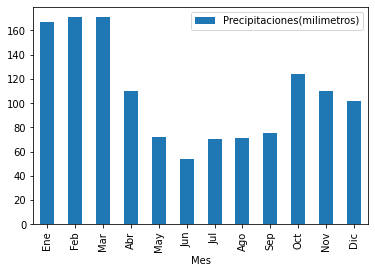

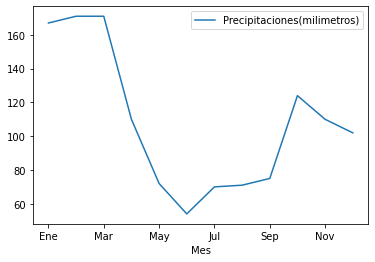

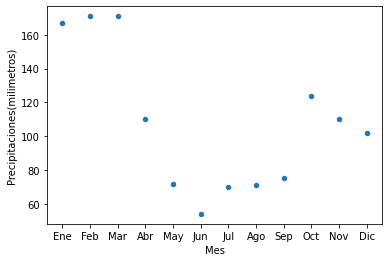

In [60]:
from __future__ import print_function
import pandas as pd
from pandas import DataFrame
import numpy
import numpy
from google.colab import files
import matplotlib.pyplot as plt

precipita = pd.read_csv('https://raw.githubusercontent.com/gmmendez/EA2SOA/master/Precipitaciones.csv', sep=',')
df = DataFrame(precipita,columns=['Mes','Precipitaciones(milimetros)'])
print(df)

df.plot(x ='Mes', y='Precipitaciones(milimetros)', kind = 'bar')
plt.show()
df.plot(x ='Mes', y='Precipitaciones(milimetros)', kind = 'line')
plt.show()
df.plot(x ='Mes', y='Precipitaciones(milimetros)', kind = 'scatter')
plt.show()

In [61]:
numpy.savetxt('Temperaturas.txt', df.values, delimiter="\t", fmt='%s')
files.download('Temperaturas.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
# Codigo Python, que tiene el código C de la ejecución del cálculo de la evapotranspiracion.
code = """
// Calculo de evapotranspiracion con OpenMP, usando c, ejecutado en Colab. 

#include <iostream>
#include <vector>
#include <cstdlib>
#include <sys/time.h>
#include <omp.h> //Se incluye la biblioteca para utilizar OpenMP

int main(int argc, char* argv[]) 
{ 
  int i,c;

  //Verifico si la cantidad de parámetros que ingresó el usuario es correcta.
  if( argc != 3 )
  {
      std::cerr<< " Error en los parametros ingresados: (Tamanio vector), (ciclos ejecucion)."<<argc<<std::endl;
      exit( -1 );
  }

  //Leo los parámetros
  int cantidad_N = atoi( argv[1] );
  int ciclos     = atoi( argv[2] );


  // Defino la memoria de los vectores.
  std::vector<double> ET0( cantidad_N );
  std::vector<double> Kc( cantidad_N );
  std::vector<double> ET( cantidad_N );

  //Asigno a cada vector números aleatorios
  for (int i=0;i<ET.size();i++)
  {
    ET0[i] = rand() % 10;
    Kc[i] = (float)rand() / RAND_MAX;
  }


  for(c=0;c<ciclos;c++)
  {
    #pragma omp parallel for
    for(i=0;i<ET.size();i++)
    {
      ET[i] = ET0[i] * Kc[i];
    }
  }

  //Realizo la impresión de los vecotres ET0, Kc y el resultado: ET
  std::cout<<"ET0 : ["; 
  for(i=0;i<ET0.size();i++)
  {
    std::cout<<ET0[i]<< ", ";
  }
  std::cout<<"]"<<std::endl;

  std::cout<<"Kc : ["; 
  for(i=0;i<Kc.size();i++)
  {
    std::cout<<Kc[i]<< ", ";
  }
  std::cout<<"]"<<std::endl;
  
  std::cout<<"ET : ["; 
  for(i=0;i<ET.size();i++)
  {
    std::cout<<ET[i]<< ", ";
  }
  std::cout<<"]"<<std::endl;

}
// ----------------------------------------------------------------------------

"""
text_file = open("Evapotranspiracion.cpp", "w")
text_file.write(code)
text_file.close()

In [46]:
!g++ -o ET -fopenmp Evapotranspiracion.cpp

In [47]:
%env OMP_NUM_THREADS=3
!./ET 12 20

env: OMP_NUM_THREADS=3
ET0 : [3, 7, 3, 6, 9, 2, 0, 3, 0, 2, 1, 7, ]
Kc : [0.394383, 0.79844, 0.197551, 0.76823, 0.55397, 0.628871, 0.513401, 0.916195, 0.717297, 0.606969, 0.242887, 0.804177, ]
ET : [1.18315, 5.58908, 0.592654, 4.60938, 4.98573, 1.25774, 0, 2.74859, 0, 1.21394, 0.242887, 5.62924, ]


**4. Tabla de pasos**

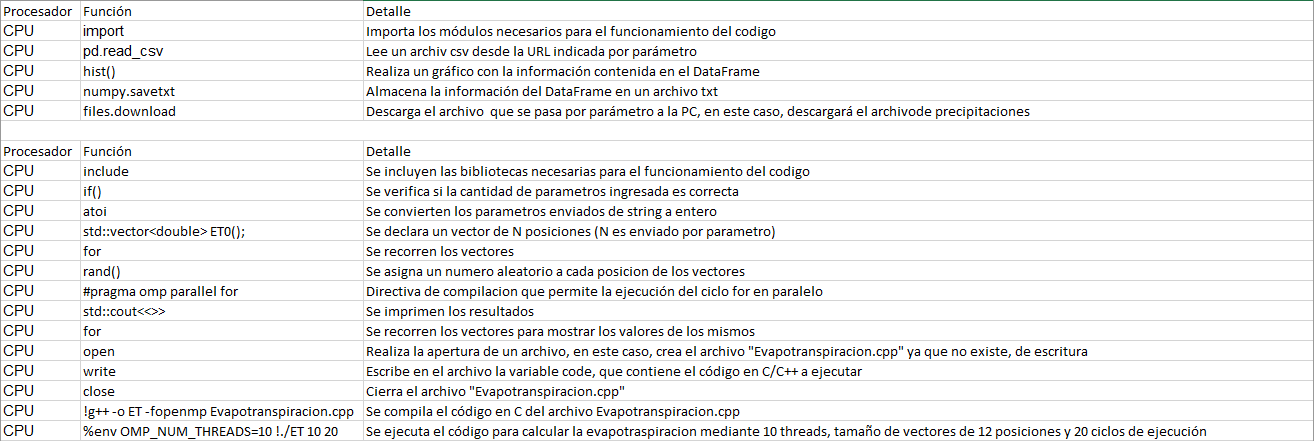

**5. Conclusiones**

*Repaso*

En el presente cuaderno se hace uso de la API Pandas, que es ideal para la realización de tablas y gráficos ya que nos permite manipular datos en columnas y analizar datos de entrada. A su vez, nos permite obtener facilmente datos de archivos csv que se encuentran subidos a una plataforma distinta a Colab, como puede ser GitHub, trabajar con dichos datos y generar un nuevo archivo con toda esta información para luego descargarlo a cualquier terminal que ejecute la solucion.

A su vez, fue implementado el procesamiento de varios hilos en paralelo, que nos permite aprovechar al máximo los núcleos del procesador sobre el cual se ejecuta la solucion, ya que en cada core se va a ejecutar un hilo, haciendo de esta manera más eficiente y rápida la ejecución del ejercicio.


*Lecciones aprendidas*

En el presente ejercicio pude explorar de forma detallada las distintas funcionalidades que ofrece Colab, que podemos decir que es un entorno potente en el cual no solamente podemos hacer uso de una GPU en caso de que no dispongamos de una en nuestra terminal, sino que también permite ejecutar programas en lenguaje Python utilizando todas sus bibliotecas.

A su vez, pude tener una primera aproximación a OpenMP, una biblioteca que nos permite crear programas paralelos y portables utilizando memoria compartida.

*Sugerencias para continuar con el ejercicio*

Para continuar el ejercicio, como posible sugerencia, considero que se podría obtener información oficial de archivos confeccionados por el Servicio Meteorológico Nacional con información acerca de las precipitaciones de los años anteriores para que de esta manera, el usuario pueda ver datos actualizados. A su vez, otra posible sugerencia es la de calcular en la estimación evapotranspiración de referencia (ET0) en hilos a los que se calcula la evapotranspiración del cultivo, para de esta manera aprovechar aun mas las ventajas de paralelizacion que nos ofrece OpenMP.

**6. Bibliografia**

[1] Documentacion Numpy: [Sitio web](https://numpy.org)

[2] Documentacion OpenMP: [Sitio web](https://www.openmp.org/)

[3] Evapotranspiracion INTA: [Sitio web](https://inta.gob.ar/sites/default/files/script-tmp-inta_tc_evapotranspiracion_y_kc_cultivos.pdf)

[4] Programacion Paralela OpenMP: [Sitio web](http://ocw.uc3m.es/ingenieria-informatica/arquitectura-de-computadores/materiales/es-m6-01-openmp-ocw.pdf)